# Title: proxy_server_2_8889
# PID: A69028485
# Name: William Wei
# GitHub username: William Lien Chin Wei
# Email (registered with GitHub): williams19834812@gmail.com
# Video demonstration of your working code on https://www.youtube.com/watch?v=QLHV0BKBerE

# The communication part requires the following
# <font color='red'>For this assignment, it is fine to set up both of two servers on @ $\textbf{PYNQ}$ to communicate.</font>
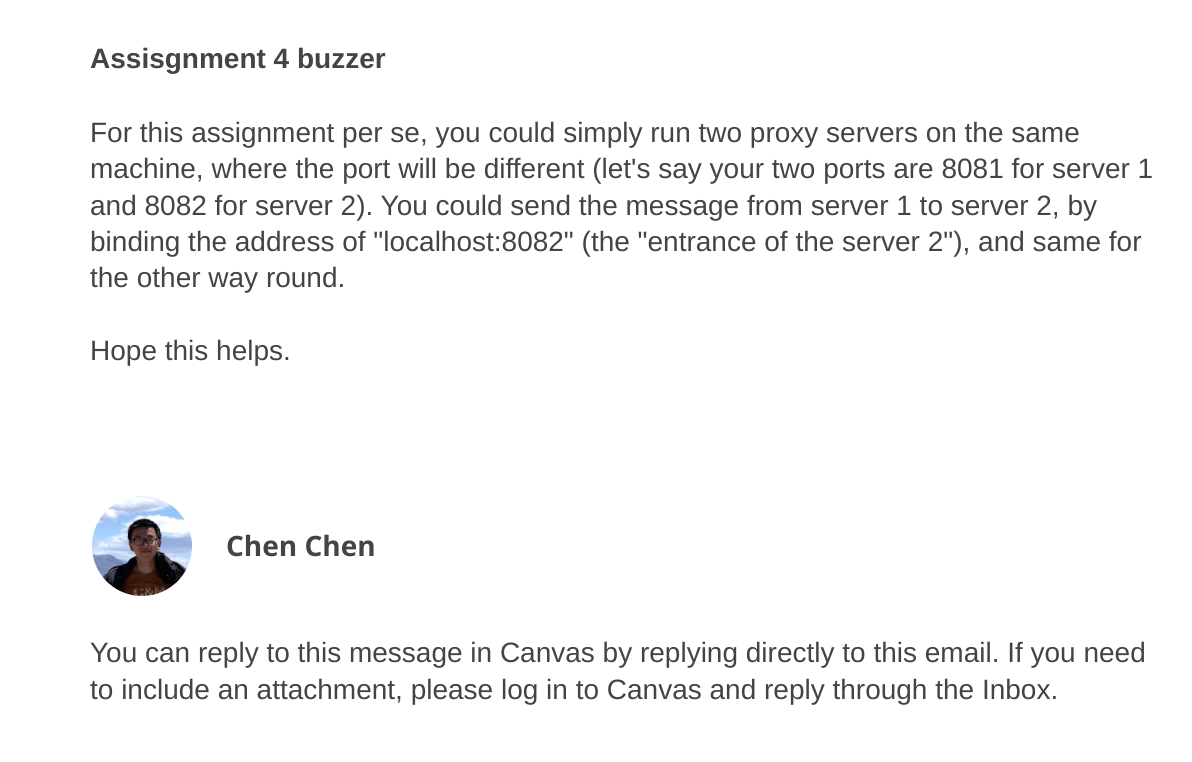

# <font color='red'>As shown below, instead of connecting via two separate PYNQ boards, server_2 is simulated as PYNQ2.</font>
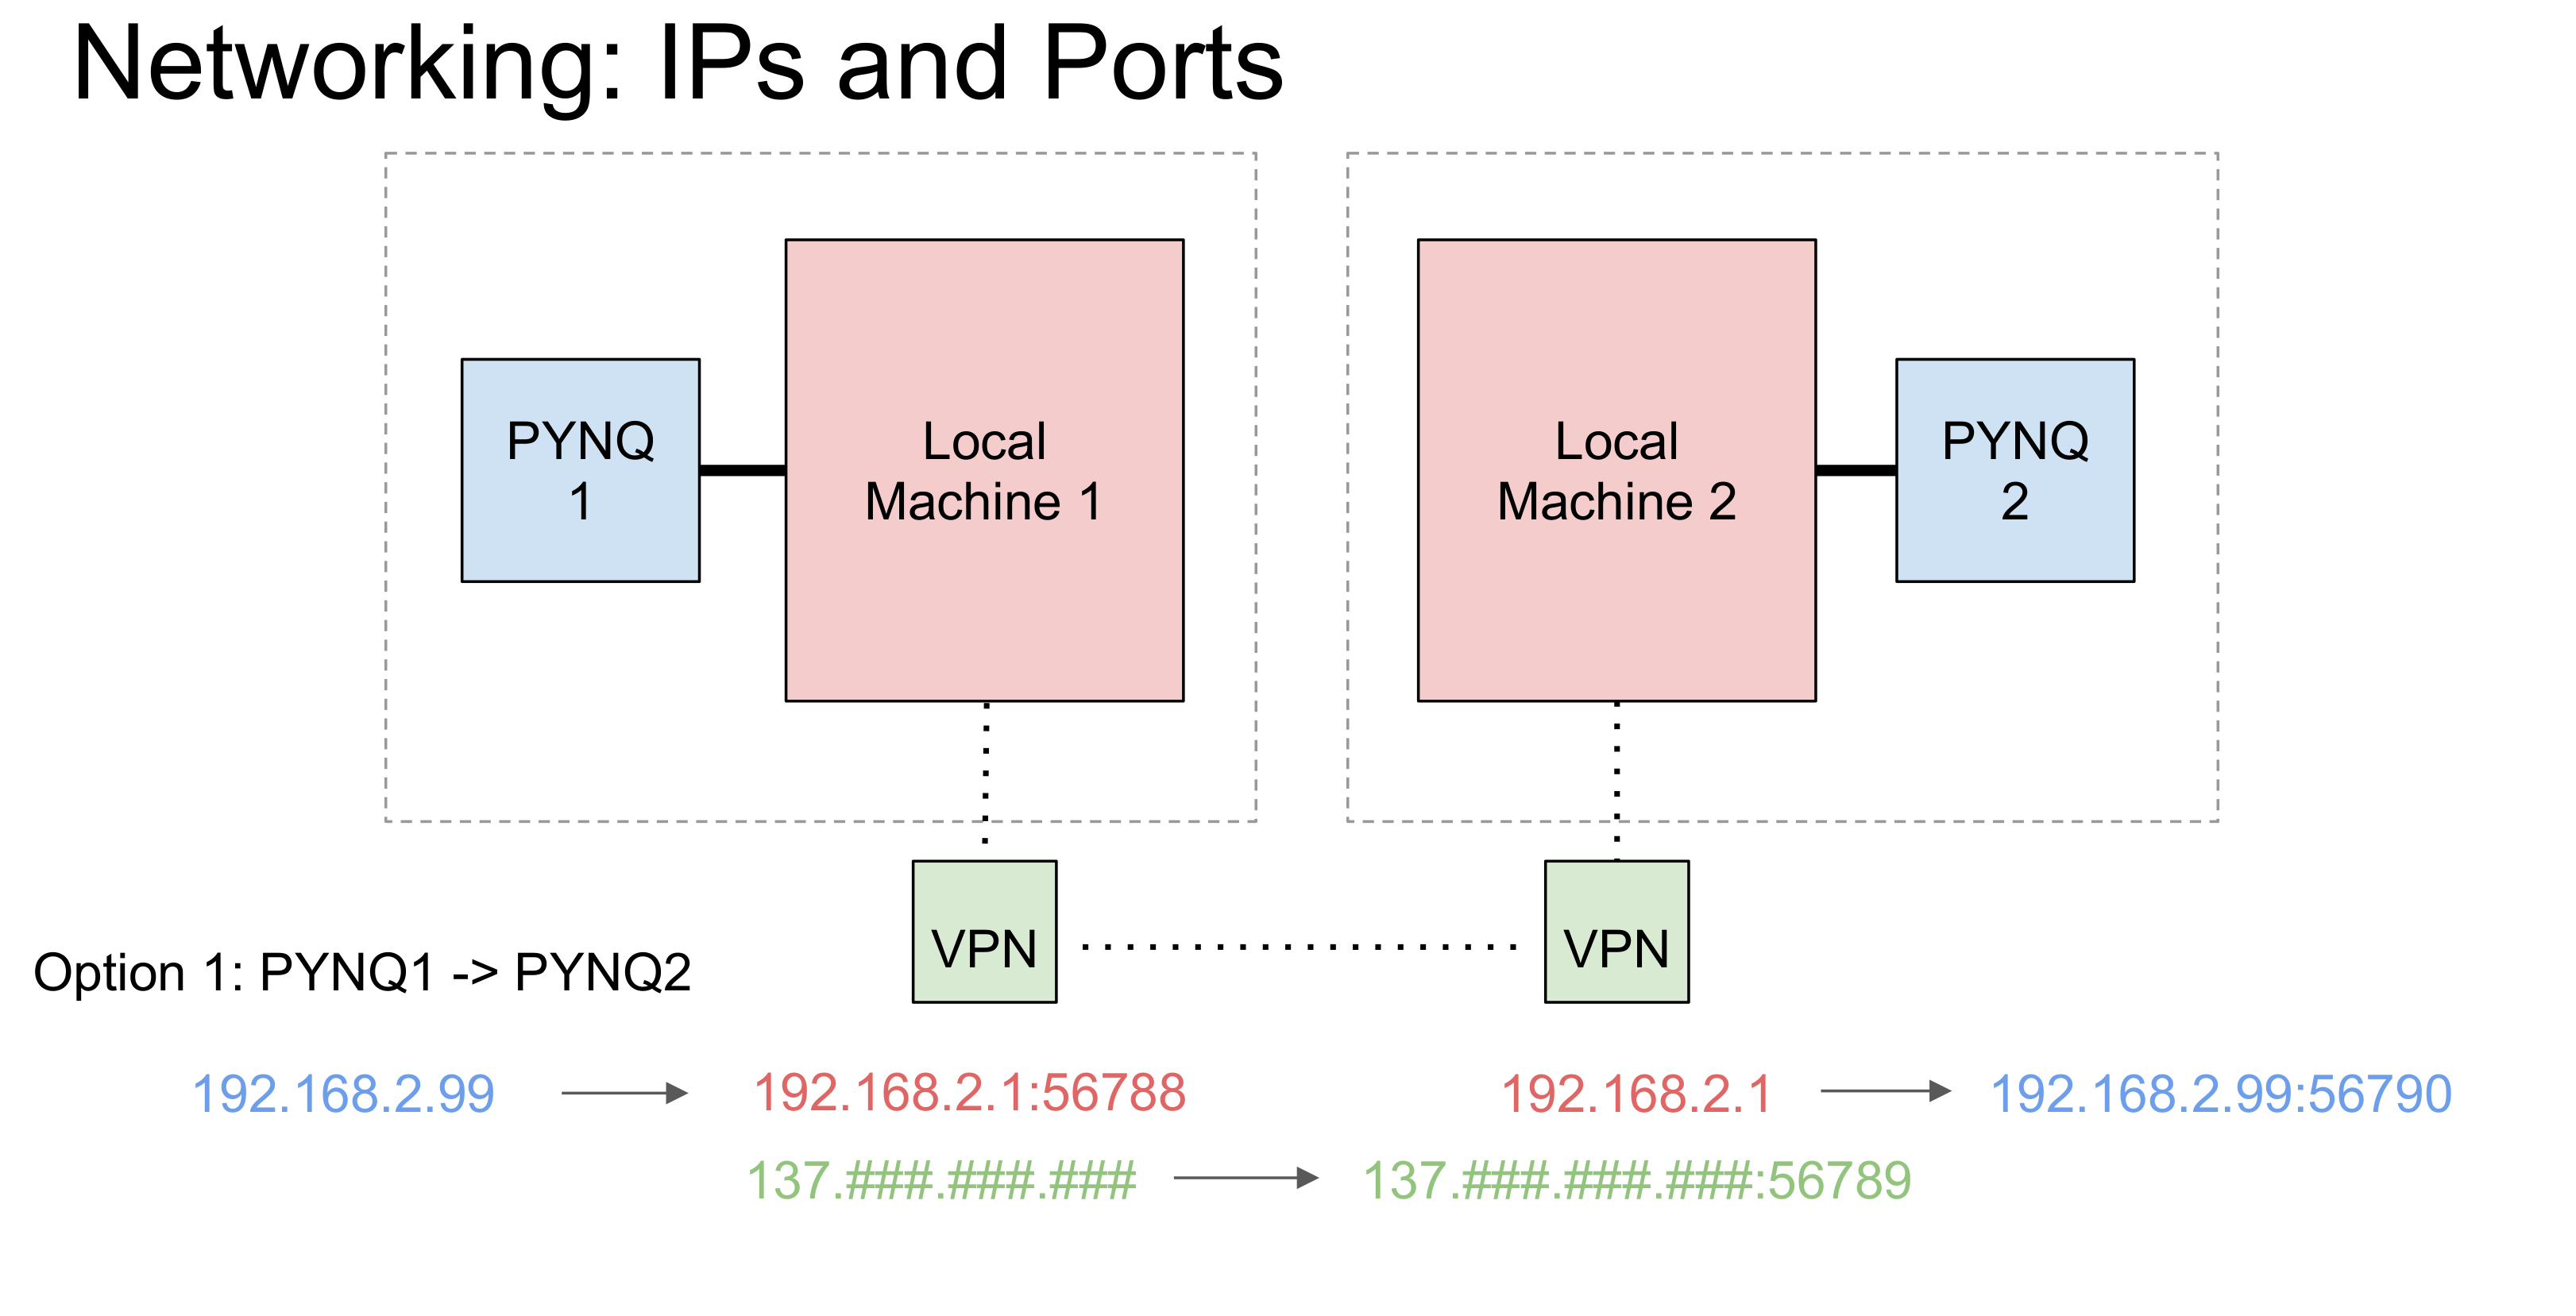


• Using $\textbf{multiprocessing}$ library, create two processes: one process for server and one process for
client. <br>

In [1]:
from pynq.overlays.base import BaseOverlay
import multiprocessing
import threading
import time
import socket
import os

base = BaseOverlay("base.bit")
btns = base.btns_gpio
ctdClThd = []   # connected client thread
procs = []      # process

In [2]:
%%microblaze base.PMODA

#include "gpio.h"
#include "pyprintf.h"

//Function to turn on/off a selected pin of PMODB
void write_gpio(unsigned int pin, unsigned int val){
    if (val > 1){
        pyprintf("pin value must be 0 or 1");
    }
    gpio pin_out = gpio_open(pin);
    gpio_set_direction(pin_out, GPIO_OUT);
    gpio_write(pin_out, val);
}

//Function to read the value of a selected pin of PMODB
unsigned int read_gpio(unsigned int pin){
    gpio pin_in = gpio_open(pin);
    gpio_set_direction(pin_in, GPIO_IN);
    return gpio_read(pin_in);
}

In [3]:
def runBuzzer(rt, f):
    T = 1/f # period
    maxCnt = int(rt / T) # number of period 
    interval = 1/(2*f)
    print('running ', maxCnt * 2 * interval, ' sec\n'
          'max count: ', maxCnt, 
          'period: ', 2 * interval)

    write_gpio(3, 1)                  #  middle pin power  (3.3V)
    cnt = 0
    while (cnt<maxCnt):
        cnt+=1
        write_gpio(2, 1)              # ‘+’ pin, signal you want to write   
        time.sleep(interval)
        write_gpio(2, 0)
        time.sleep(interval)
   
    print('done, buzzer is off...')
    setAllOff()

def setAllOff():
    for i in range(0, 8):
        write_gpio(i, 0) 

# Test btns-triggered buzzer function


In [4]:
# buzzer and btns
import asyncio

cond = True
start = 0

async def operation(rt, f, _loop):
    global cond, start
    while cond:
        if start == 1:
            await asyncio.sleep(0.3)
            #print(">>>>>>BTN0")
            
        if start == 2: 
            await asyncio.sleep(0.3)
            setAllOff()
            runBuzzer(rt, f)
            start = 0
            
        if start == 4:
            #pass
            await asyncio.sleep(0.3)
            cond = False
            _loop.stop()
            

async def get_btns(_loop):
    global cond, start
    while cond:
        await asyncio.sleep(0.01)
        #print('cond')
        if btns.read() == 1: # the first button on the very right
            start = 1
            await asyncio.sleep(0.3)
            print("pressing BTN0, server start...")
                    
        elif btns.read() == 2: # buzzer
            start = 2
            await asyncio.sleep(0.3)
            print("pressing BTN1, buzzer starts...")
   
        elif btns.read() == 4: # blinking blue led
            start = 3
            cond = False
            await asyncio.sleep(0.3)
            print('\n')
            print("pressing BTN2, disconnects from the server")
            _loop.stop()

In [5]:
def runBottonLoop(rt, f):
    loop = asyncio.new_event_loop()    # Create and return a new event loop object.

    loop.create_task(operation(rt, f, loop))
    loop.create_task(get_btns(loop))
    loop.run_forever()
    loop.close()   
    print("Exit loop...")

• Each board will need to have the following happening. <br>

– The $\textbf{server}$ process should always be running in $\textbf{listening}$ mode. <br>

– By $\textbf{pushing one of the buttons}$ on the PYNQ board, the $\textbf{client has to start}$ and connect to the server board. <br>

– After client connects, $\textbf{pressing a different button}$ should emit a tone on the other PYNQ board.
∗ Pushing the button should emit a ~0.5 second tone each time it’s pressed <br><font color='blue'> 
($\textbf{Note, below demo uses 5 seconds period for each press}$)</font>.



In [6]:
def runServer(i_cpu, port):
    global cond, start
    """
    see async def operation(rt, f) above
    cond    condition for loop
    start   choicse decoded for simulating btns
    """
    print("Server running on CPU_{} at port {}...\n".format(i_cpu, port))
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    # 1. Bind the socket to the pynq board 
    #<CLIENT-IP>, 0.0.0.0' for any clients, at port <LISTENING-PORT>
    sock.bind(('0.0.0.0', port))
    
    # 2. Accept connections
    # Enable a server to accept connections
    sock.listen()
    
    conn, addr = sock.accept()
    print('Connected by', addr)
    
    if addr:
        rt, f= 0.5, 5  #rt: run time (sec), f: tone_freq (Hz)
        t = threading.Thread(target=runBottonLoop, args=(rt, f, ))
        name = t.getName()
    
    condLoop = True
    while condLoop:
        data = conn.recv(1024)
        choice = data.decode('ASCII')
        if not data: break
        print('Received', str(choice))      
        
        if int(choice) == 1:
            if t.getName():
                start = 1
                print("pressing BTN0, client {} connects to the server...".format(addr))
                t.start()
                print('{} starts\n'.format(name))
                   
        if int(choice) == 2:
            if t.is_alive():
                start = 2
                print("pressing BTN1, buzzer starts...")
            
        if int(choice) == 4:    
            start = 4
            print("pressing BTN2, client {} disconnects to the server".format(addr))
            if t.is_alive():
                t.join()
                print('{} joined\n'.format(name))
            condLoop = False
             
    
    
    sock.close()
    print('Sock closed.')  


# <font color='blue'>Server 2 @ $\textbf{PYNQ}$ @ 127.0.0.1:8889</font>

<br><font color='blue'> 
$\textbf{Case 2, server 2 is connected by client 1 and buzz.}$
</font>.

In [9]:
# creating process, the first arg defines which CPU to run the 'target' on
i_cpu, port = 1, 8889 #'PYNQ'
pS = multiprocessing.Process(target=runServer, args=(i_cpu, port,))

# Execute the command (a string) in a subshell,  
# taskset is an os command to pin the process to a specific CPU
os.system("taskset -p -c {} {}".format(i_cpu, pS.pid))

pS.start()          # start the process
procs.append(pS)
pSName = pS.name    # get process1 name

pS.join()
print("{} joined.".format(pSName))

Server running on CPU_1 at port 8889...

Connected by ('192.168.2.99', 55298)
Received 1

pressing BTN0, client ('192.168.2.99', 55298) connects to the server...
Thread-5 starts

pressing BTN1, buzzer starts...
Received 2

pressing BTN1, buzzer starts...
running  0.4  sec
max count:  2 period:  0.2
done, buzzer is off...
Received 2

pressing BTN1, buzzer starts...
running  0.4  sec
max count:  2 period:  0.2
done, buzzer is off...
Received 4

pressing BTN2, client ('192.168.2.99', 55298) disconnects to the server
Exit loop...
Thread-5 joined

Sock closed.
Process-2 joined.



# <font color='blue'>Client 2 @ $\textbf{PYNQ}$</font>

In [7]:
def runClient(i_cpu, ip, port):
    global cond, start
    
    print("Client running on CPU_{} connecting server @ ip {}:port {}...\n".format(i_cpu, ip, port))
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    # 1: Connect the socket (sock) to the <SERVER-IP> and choosen port <LISTENING-PORT>
    sock.connect((str(ip), port))
    

    # 2: Send messages
    t = threading.Thread(target=runBottonLoop_2, args=())
    name = t.getName()
    t.start()
    
    condLoop = True
    start = 0
    while condLoop:
        if start == 0:
            time.sleep(0.3)
        if start == 1:
            time.sleep(0.3)
              
            bMsg = (str(start)+'\n').encode('ASCII')
            sock.send(bMsg)
            #print('Here', str(start)) 
            start = 0
            
        if start == 2:
            time.sleep(0.3)
            
            bMsg = (str(start)+'\n').encode('ASCII')
            sock.send(bMsg)
            #print('Here', str(start))
            start = 0

            
        if start == 4:    
            time.sleep(0.3)
            
            bMsg = (str(start)+'\n').encode('ASCII')
            sock.send(bMsg)
            #print('Here', str(start))
            start = 0          
            condLoop = False
    
    print('{} joined'.format(name))
    t.join()
    
    # 3: Close the socket
    sock.close()

    
async def get_btns_2(_loop):
    global cond, start
    while cond:
        await asyncio.sleep(0.01)
        #print('cond')
        if btns.read() == 1: # the first button on the very right
            start = 1
            await asyncio.sleep(0.3)
            print("pressing BTN0")
                    
        elif btns.read() == 2: # buzzer
            start = 2
            await asyncio.sleep(0.3)
            print("pressing BTN1")
   
        elif btns.read() == 4: # blinking blue led
            start = 4
            cond = False
            await asyncio.sleep(0.3)
            print('\n')
            print("pressing BTN2, disconnects from the server")
            _loop.stop()
            
def runBottonLoop_2():
    loop = asyncio.new_event_loop()    # Create and return a new event loop object.

    loop.create_task(get_btns_2(loop))
    loop.run_forever()
    loop.close()   
    print("Exit loop...")

In [8]:
# creating process, the first arg defines which CPU to run the 'target' on
i_cpu, ip, port = 1, '127.0.0.1', 8888     # 127.0.0.1 is localhost of 
pC = multiprocessing.Process(target=runClient, args=(i_cpu, ip, port, ))

# Execute the command (a string) in a subshell,  
# taskset is an os command to pin the process to a specific CPU
os.system("taskset -p -c {} {}".format(i_cpu, pC.pid))

pC.start()          # start the process
procs.append(pC)
pCName = pC.name    # get process1 name


Client running on CPU_1 connecting server @ ip 127.0.0.1:port 8888...

pressing BTN0
pressing BTN1
pressing BTN1
pressing BTN1
pressing BTN1


pressing BTN2, disconnects from the server
Exit loop...
Thread-5 joined
